# `0_intro.ipynb`

This notebook tests that required modules can be imported. It also contains a few examples of the functions in `common.py` to initialize the fields, and other examples that will be used in the following notebooks.

## Testing the setup

In [1]:
import os
# Remove warning when importing Taichi due to old glibc
os.environ["TI_MANYLINUX2014_OK"] = "1"
import time
import timeit
import numpy
import pandas
import numba
import numexpr
import taichi
import matplotlib
import gt4py

[Taichi] version 1.6.0, llvm 16.0.0git, commit f1c6fbbd, linux, python 3.9.4


[I 09/09/23 19:40:02.431 13225] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


## Initializing fields

In [2]:
from common import initialize_field, plot_field, save_result, compare_results, read_results

In [3]:
NX = 128
NY = 128
NZ = 80

### Initial values

We can initialize the 3D fields with a few different patterns: random, horizontal bars, vertical bars and a square.

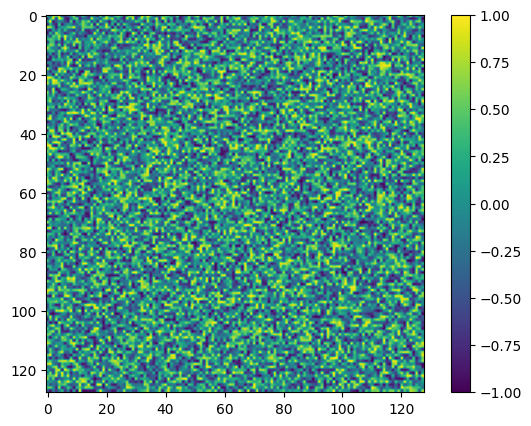

In [4]:
field = initialize_field(NX, NY, NZ, mode="random")
plot_field(field)

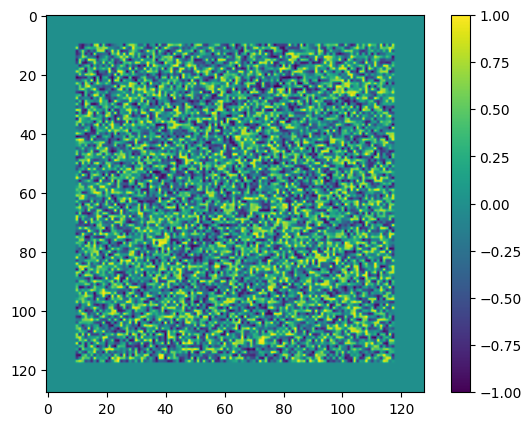

In [5]:
field = initialize_field(NX, NY, NZ, mode="random", num_halo=10)
plot_field(field)

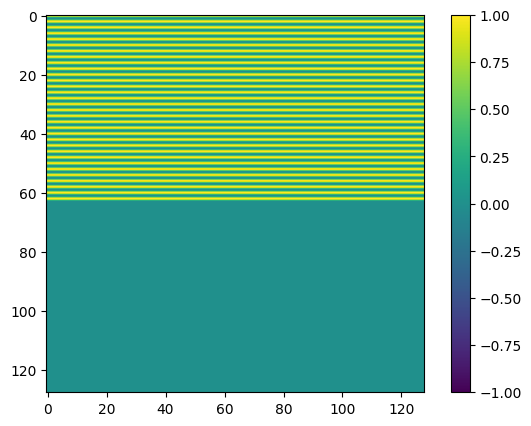

In [6]:
field = initialize_field(NX, NY, NZ, mode="horizontal-bars")
plot_field(field)

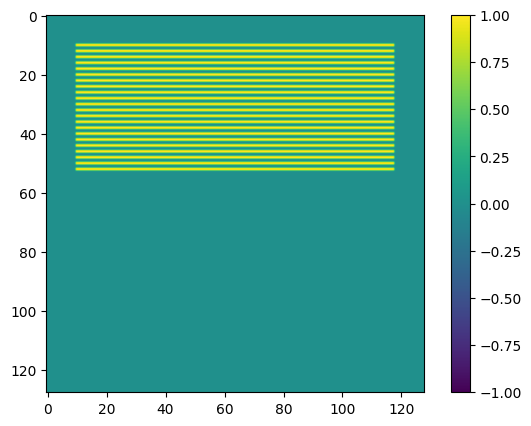

In [7]:
field = initialize_field(NX, NY, NZ, mode="horizontal-bars", num_halo=10)
plot_field(field)

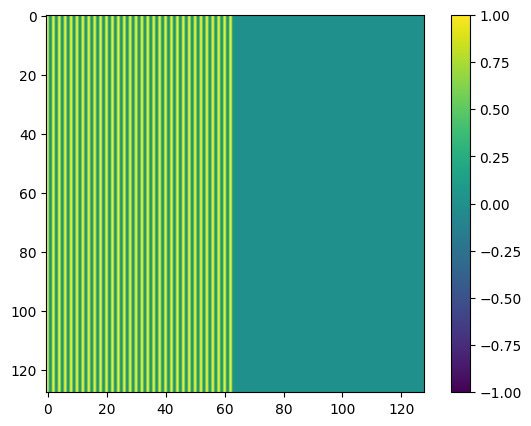

In [8]:
field = initialize_field(NX, NY, NZ, mode="vertical-bars")
plot_field(field)

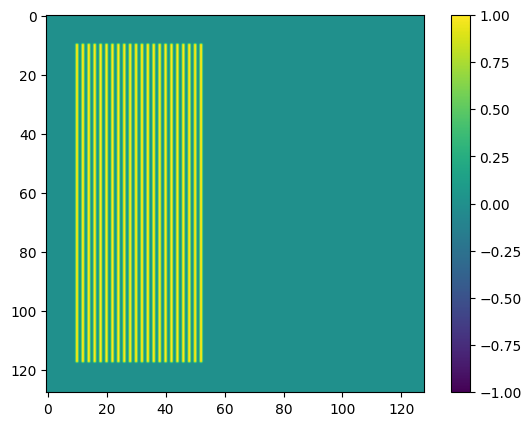

In [9]:
field = initialize_field(NX, NY, NZ, mode="vertical-bars", num_halo=10)
plot_field(field)

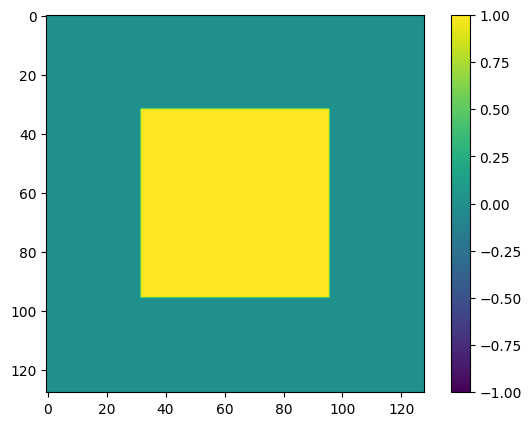

In [10]:
field = initialize_field(NX, NY, NZ, mode="square")
plot_field(field)

### Dimensions order

The underlying order of the dimensions in the NumPy arrays can be changed to any of the 6 possible permutations by using the kwarg `dim_order`. Plotting the field will still work as expected if we use the same kwarg there.

(80, 128, 128)

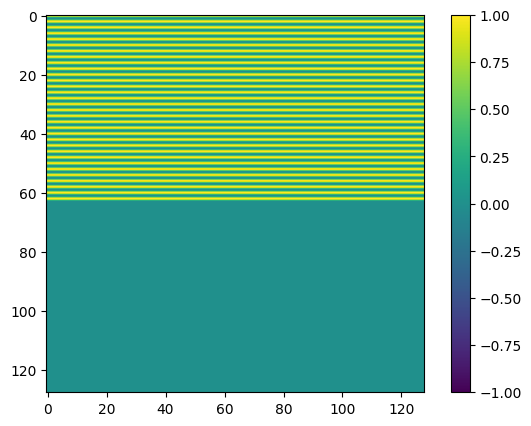

In [11]:
dim_order = "ZXY"
field = initialize_field(NX, NY, NZ, dim_order=dim_order, mode="horizontal-bars")
plot_field(field, dim_order=dim_order)
field.shape

(128, 80, 128)

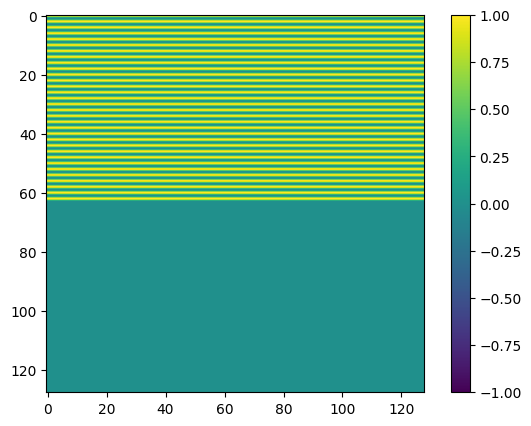

In [12]:
dim_order = "YZX"
field = initialize_field(NX, NY, NZ, dim_order=dim_order, mode="horizontal-bars")
plot_field(field, dim_order=dim_order)
field.shape

### C-style (row-major) and Fortran-style (col-major) arrays

Finally, NumPy arrays can be stored row-major or col-major. More details for N-dimensional arrays will be explained in the [lists and NumPy notebook](./1_lists_numpy.ipynb)

In [13]:
field = initialize_field(NX, NY, NZ, array_order="C")
print(field.flags)
print(field.shape)
print(field.strides)

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

(80, 128, 128)
(131072, 1024, 8)


In [14]:
field = initialize_field(NX, NY, NZ, array_order="F")
print(field.flags)
print(field.shape)
print(field.strides)

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

(80, 128, 128)
(8, 640, 81920)


## Benchmarking in Jupyter


### Measuring running times

Since we will be working with Python code all the project, we will run all the tests, examples and benchmarks in Jupyter notebooks. In order to benchmark execution times we will use the built-in magic commands `%timeit` and`%%timeit`. Both commands are equivalent, but `%timeit` only affects a single line, while `%%timeit` measure the execution time of the whole cell.

According to [the IPython documentation](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit)

> In cell mode, the statement in the first line is used as setup code (executed but not timed) and the body of the cell is timed. The cell body has access to any variables created in the setup code.

Let's quickly verify this

In [15]:
%%timeit
1 + 1

6.99 ns ± 0.0389 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [16]:
%%timeit
time.sleep(.1)  # This line is executed and measured
1 + 1

100 ms ± 2.26 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%%timeit time.sleep(.1)  # This line is executed but not measured
1 + 1

6.29 ns ± 0.0389 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


For slow cells we can manually specify the number of repetitions and the number of runs per repetition.

In [18]:
%%timeit -n1 -r3
time.sleep(1)  # By default, %%timeit would repeat 7 times

1 s ± 10.4 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


The output of the magic command can be saved to a variable using the other built-in magic command `%capture`

In [19]:
%%capture result
%%timeit -n1 -r3
time.sleep(1)

In [20]:
print(type(result))
print(result)

<class 'IPython.utils.capture.CapturedIO'>
1 s +- 12.2 us per loop (mean +- std. dev. of 3 runs, 1 loop each)



However, it is more useful, to store the output as a `TimeitResult`, so that we can access the avergage and standard deviation values as floats.

In [21]:
%%timeit -n1 -r3 -o
time.sleep(1)

1 s ± 5.64 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 1 s ± 5.64 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [22]:
result = _

In [23]:
print(type(result))
print(result.average)
print(result.stdev)

<class 'IPython.core.magics.execution.TimeitResult'>
1.001056999977057
5.642361315980416e-06


### Saving results

In order to automatize saving the benchmark results we have written the function `save_result()`. The first time we call the function, or if we want to overwrite previous results we can pass `overwrite=True` and `header=True`. Later, we can ommit them and new results will be appended at the end of the file.

In [24]:
save_result(result, "test_3s_sleep", overwrite=True, header=True)

In [25]:
save_result(result, "test_3s_sleep_bis")

In [26]:
!cat results.csv

timestamp,hostname,test,timeit_avg,timeit_std
2023-09-09 17:40:47.755340,nid06395,test_3s_sleep,1.00e+00,5.64e-06
2023-09-09 17:40:47.789848,nid06395,test_3s_sleep_bis,1.00e+00,5.64e-06


### Reading results

Results from the csv file can be read using the function `read_results()`

In [27]:
read_results("test_3s_sleep_bis")

1.0

In [28]:
read_results("test_3s_sleep_bis", as_array=False)

,timestamp,hostname,test,timeit_avg,timeit_std
1,2023-09-09 17:40:47.789848,nid06395,test_3s_sleep_bis,1.0,0.000006


Let's clean the csv file from this dummy tests and just leave the header

In [29]:
save_result(None, overwrite=True, header=True)

In [30]:
!cat results.csv

timestamp,hostname,test,timeit_avg,timeit_std


### Comparing results

To avoid confusion about expressions like *"A is x times faster than B"*, "B is y times slower than A", or *"A is z % slower than B"*, in all our notebooks we will only use these two expressions to compare benchmarking times: 

A is x times faster than B, i.e., $B = xA$, and

A is x % faster than B, i.e., $B - A = \dfrac{xA}{100}$

Example: computing a stencil takes 15.3 seconds on a laptop (A) and 6.5 on a desktop (B)

In [31]:
A = 15.3
B = 6.5

print(f'The desktop is {compare_results(B, A, "faster")} times faster than the laptop')
print(f'The desktop is {compare_results(B, A, "faster-%")} faster than the laptop')

The desktop is ~2.4 times faster than the laptop
The desktop is ~135% faster than the laptop


Example: A = 42 ms and B = 1.07 s

In [32]:
A = 42e-3
B = 1.07

print(f'A is {compare_results(A, B, "faster")} times faster than B')
print(f'A is {compare_results(A, B, "faster-%")} faster than B')

A is ~25 times faster than B
A is ~2448% faster than B


In [33]:
A = 42e-3
B = 58e-3

print(f'A is {compare_results(A, B, "faster")} times faster than B')
print(f'A is {compare_results(A, B, "faster-%")} faster than B')

A is ~1.4 times faster than B
A is ~38% faster than B
